# Contextualisation of FragPipeAnalyst with optimal directed prize collecting steiner trees

In this notebook, we illustrate how to run the [PHONEMES-ILP](https://pubs.acs.org/doi/full/10.1021/acs.jproteome.0c00958) method using the flexible optimal PCST CORNETO implementation with the [FragPipeAnalyst](http://fragpipe-analyst.nesvilab.org/) output, an R package and Shiny app that processes the output of [FragPipe](https://fragpipe.nesvilab.org/), a state-of-the-art software suite for the analysis of proteomics raw data. We use the phosphoproteomics data described in the [FragPipeAnalyst manuscript](https://www.biorxiv.org/content/10.1101/2024.03.05.583643v1), which contains the differential phosphoproteomic profiles of ccRCC CPTAC patients. 


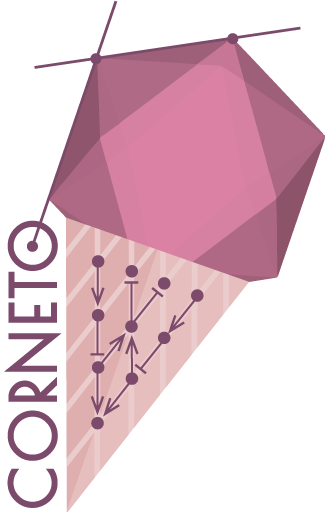

In [1]:
# generic and data science
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

# network handling
import networkx as nx

# supports owncloud downloads: pip install pyocclient
import owncloud

# corneto
import corneto as cn
from corneto._graph import EdgeType
from corneto.methods.steiner import exact_steiner_tree

plt.rcParams['text.usetex'] = False
plt.rcParams["pdf.use14corefonts"] = False

cn.info()

We first load the data, which contains the logFC and adjusted P value of the differential analysis of tumor and normal adjacent tissue samples. Next, we load the prior knowledge network from OmniPath API. For this example, we will use all the Kinase-Substrate interactions present in the enzyme-PTM omnipath dataset. We also add the 'integrator' nodes: Nodes that connect phosphosites back to allow network flow.

In [2]:
# Create a temporary directory
with tempfile.TemporaryDirectory() as tmpdirname:
    cache_file = os.path.join(tmpdirname, 'fragpipe_diff.csv')
    
    if not os.path.exists(cache_file):
        oc = owncloud.Client.from_public_link('https://oc.embl.de/index.php/s/UYitbSUg7uaVVWQ')
        oc.get_file('/fragpipe_output.csv', cache_file)
    
    data = pd.read_csv(cache_file)
data

,GeneSite,Tumor_vs_NAT_diff,Tumor_vs_NAT_p.adj
0,A1BG_T84,-0.103680,0.681969
1,A1BG_T87,-0.103680,0.681969
2,A1BG_Y91,-0.103680,0.681969
3,A1CF_T499,-0.157574,0.520129
4,A2M_S249,0.202011,0.709314
...,...,...,...
34043,_S285,0.272699,0.229879
34044,_S294,-0.383776,0.098305
34045,_S67,-0.257512,0.189884
34046,_S93,0.175795,0.185768


In [3]:
# load PKN via OmniPath
op_enzsub = pd.read_csv('https://omnipathdb.org/enzsub?genesymbols=1', sep = '\t')
# we filter to phosphorylation and dephosphorylation events and create the kinase-substrate columns
op_enzsub = op_enzsub[op_enzsub['modification'].isin(['phosphorylation', 'dephosphorylation'])]
op_enzsub['phosphosite'] = op_enzsub['substrate_genesymbol'] + '_' + op_enzsub['residue_type'] + op_enzsub['residue_offset'].astype(str)
op_enzsub = op_enzsub[['enzyme_genesymbol', 'phosphosite']].rename(columns = {'enzyme_genesymbol': 'source', 'phosphosite': 'target'})
# add integrator nodes
integrator_df = pd.DataFrame({'source': op_enzsub['target']})
integrator_df['target'] = integrator_df['source'].str.replace(r'_.*', '', regex = True)
pkn = pd.concat([op_enzsub, integrator_df]).drop_duplicates()
pkn

,source,target
0,LCK,SOCS3_Y204
1,LCK,SOCS3_Y221
2,SRC,TERT_Y707
3,FYN,FYB1_Y651
4,FYN,FYB1_Y595
...,...,...
43259,ADRB2_S165,ADRB2
43260,TIE1_Y1117,TIE1
43261,TUBB2A_S275,TUBB2A
43263,IL13RA1_Y402,IL13RA1


To run PHONEMES, we need to set a 'source' node. In other words, we need to define as starting point for the signal propagation. In this example, we use the EGF receptor (EGFR). In addition, we also need to determine which phosphosites are perturbed. We divide the phosphosites in three groups using different thresholds:

1) De-regulated (adjusted P value < 0.01 and logFC > 1)
2) Undetermined (adjusted P value < 0.01 and logFC < 1)
3) Not changing (adjusted P value > 0.01)

In [4]:
# subset network to reachable nodes
source_node = ['EGFR']
directed_g = nx.from_pandas_edgelist(pkn, source = 'source', target = 'target', create_using = nx.DiGraph)
reachable_nodes = list(nx.descendants(directed_g, source_node[0]))
directed_g = directed_g.subgraph(reachable_nodes + source_node).copy()

# create the adjacency matrix
filt_diff_table = data[data['GeneSite'].isin(reachable_nodes)].copy()
print('Number of phosphosites in the table: {}'.format(data.shape[0]))
print('Number of reachable phosphosites in the network: {}'.format(filt_diff_table.shape[0]))
print('Percentage covered: {} %'.format(round(filt_diff_table.shape[0] / data.shape[0] * 100, 2)))

Number of phosphosites in the table: 34048
Number of reachable phosphosites in the network: 3185
Percentage covered: 9.35 %


In [5]:
volcano_colors = {
    'Not changing': sns.color_palette("muted")[2],  # Green
    'Undetermined': sns.color_palette("muted")[0],  # Blue
    'De-regulated': sns.color_palette("muted")[3],  # Red
}

label
Not changing    2337
Undetermined     696
De-regulated     152
Name: count, dtype: int64


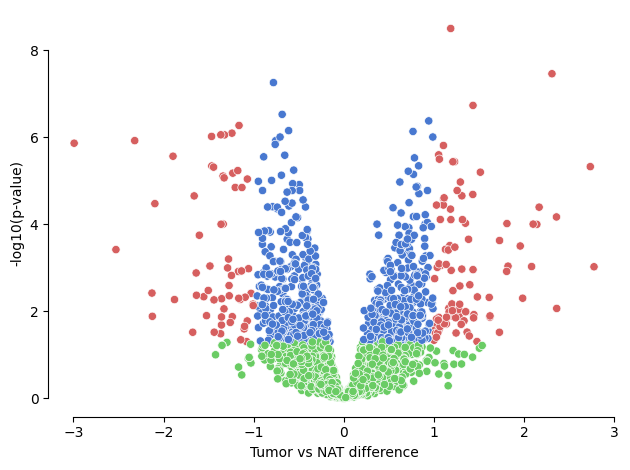

In [6]:
filt_diff_table['sig'] = -np.log10(filt_diff_table['Tumor_vs_NAT_p.adj'])
filt_diff_table['label'] = 'Not changing'
filt_diff_table.loc[(filt_diff_table['Tumor_vs_NAT_p.adj'] < 0.05) & (filt_diff_table['Tumor_vs_NAT_diff'].abs() > 1), 'label'] = 'De-regulated'
filt_diff_table.loc[(filt_diff_table['Tumor_vs_NAT_p.adj'] < 0.05) & (filt_diff_table['Tumor_vs_NAT_diff'].abs() < 1), 'label'] = 'Undetermined'
sns.scatterplot(
    x=filt_diff_table['Tumor_vs_NAT_diff'],
    y=filt_diff_table['sig'],
    hue=filt_diff_table['label'],
    palette=volcano_colors,
    rasterized=True,
    legend=False
)
plt.xlabel('Tumor vs NAT difference')
plt.ylabel('-log10(p-value)')
plt.tight_layout()
sns.despine(trim=True)
print(filt_diff_table['label'].value_counts())
plt.savefig("tumor_vs_nat.pdf", format="pdf")

Now that we have defined the perturbation, the prior knowledge network and the sets of de-regulated and unchanged phosphosites, we can run PHONEMES via CORNETO. The method will try to extract a subnetwork connecting the perturbation to the de-regulated phosphosites avoiding, when possible, unchanged phosphosites. Those will only be included if they are critical to reach > 2 de-regulated phosphosites.

In [7]:
# prepare input dictionary for corneto
dereg_psites = filt_diff_table[filt_diff_table['label'] == 'De-regulated']['GeneSite'].unique().tolist()
control_psites = filt_diff_table[filt_diff_table['label'] == 'Not changing']['GeneSite'].unique().tolist()

def corneto_phonemes(network, perturb_sites, control_sites, root, weight=0.1, seed=0):

    # prepare input dictionary
    input_dict = {k: 1 for k in perturb_sites}
    input_dict.update({k: -1 for k in control_sites})
    #input_dict = {'C1': input_dict}

    # create corneto graph from networkx object
    nx_edges = [(u, v) for u, v in network.edges]
    corneto_g = cn.Graph()
    corneto_g.add_edges(nx_edges, type=EdgeType.DIRECTED, weight=weight)

    P, Gp = cn.methods.steiner.exact_steiner_tree(corneto_g, input_dict, root=source_node[0], strict_acyclic=True)
    P.solve(solver="GUROBI", verbosity=1, IntegralityFocus=1, TimeLimit=300, Seed=seed)
    # We use the variable with_flow to select the edges that have non-zero flow
    sel_edges = set(np.flatnonzero(P.expr.with_flow.value[:corneto_g.shape[1]] > 0))
    nx_edges = [(list(i)[0], list(j)[0]) for i, j in corneto_g.edge_subgraph(sel_edges).E]
    nx_output = nx.DiGraph()
    nx_output.add_edges_from(nx_edges)
    return P, nx_output

P, result = corneto_phonemes(directed_g, dereg_psites, control_psites, source_node)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 07 10:42:32 AM: Your problem has 238620 variables, 652427 constraints, and 0 parameters.
(CVXPY) Aug 07 10:42:32 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 07 10:42:32 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 07 10:42:32 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 07 10:42:32 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 07 10:42:32 AM: Compiling problem (target solver=GU

In [8]:
P.objectives[0].value, P.objectives[1].value

(25.000000000000004, 152.0)

Finally, we can render the resulting subnetwork to visualize the tree that connects the source node to as many deregulated downstream phosphosites as possible.

In [14]:
highlighted_nodes = list(source_node) + ['GSK3B', 'SGK1', 'CDK2', 'LYN']

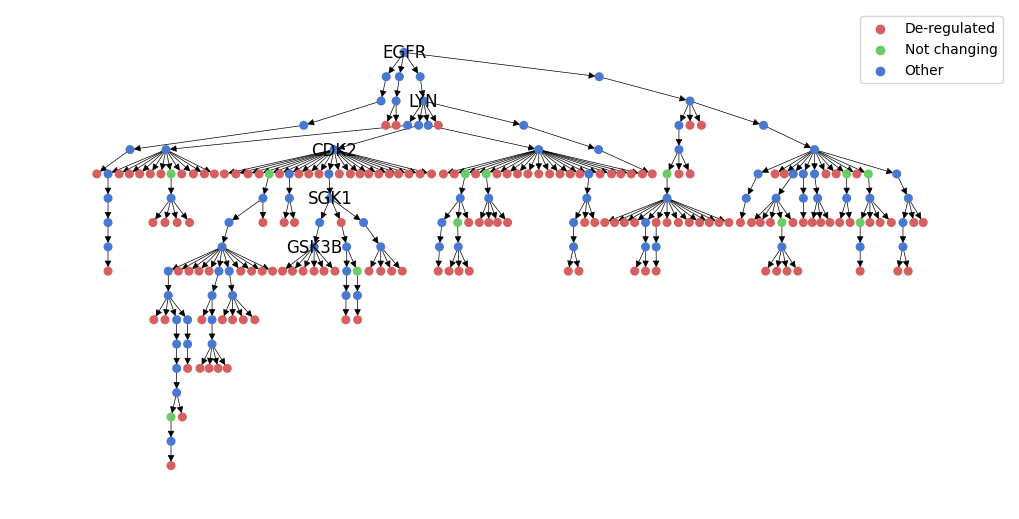

In [17]:
plt.figure(figsize=(10,5))
l = nx.nx_agraph.graphviz_layout(result, prog = 'dot')

palette = sns.color_palette("muted")
green = palette[2]
blue = palette[0]
red = palette[3]

node_colors = [red if node in dereg_psites else green if node in control_psites else blue for node in result.nodes]
node_labels = {node: node if node in highlighted_nodes else '' for node in result.nodes}
#node_labels = {node: node for node in result.nodes}
nx.draw(result, pos=l, node_color=node_colors, node_size = 30, labels = node_labels, width = 0.5, font_size=12)
plt.scatter([],[], color=red, label='De-regulated')
plt.scatter([],[], color=green, label='Not changing')
plt.scatter([],[], color=blue, label='Other')
plt.legend()
plt.savefig("fragpipe_tree.pdf", format="pdf")

In [18]:
# we can have a closer look to inferred nodes which are those not measured and explore its association with ccRCC
inferred_nodes = [ i for i in result.nodes if i not in dereg_psites + control_psites + source_node ]
unique_inferred_proteins = list(set([ i.split('_')[0] for i in inferred_nodes ]))
unique_inferred_proteins

['BUB1',
 'CSNK1D',
 'AURKB',
 'AKT1',
 'CDK2',
 'CSNK2A1',
 'SRC',
 'GSK3B',
 'PRKCA',
 'PRKCB',
 'CDK7',
 'CDK1',
 'MARK2',
 'PLK1',
 'RPS6KA5',
 'OXSR1',
 'WNK4',
 'ROCK2',
 'MAP2K1',
 'PRKACB',
 'MAPK1',
 'CAMK2D',
 'RPS6KA3',
 'CDK18',
 'CHEK1',
 'PRKACA',
 'MAPK14',
 'TTK',
 'INSR',
 'PRKCZ',
 'PPP2CB',
 'GSK3A',
 'AURKA',
 'CAMK2A',
 'LRRK2',
 'ATM',
 'EFNB2',
 'PAK4',
 'STK39',
 'PRKCI',
 'SGK1',
 'PRKD1',
 'CSNK1E',
 'PRKG1',
 'MET',
 'CDK5',
 'NEK3',
 'EPHB2',
 'PRKAA1',
 'LYN']

Clear cell renal carcinoma (ccRCC) is linked to various genes that influence cell growth, survival, and metabolism. CDK5, CDK1, and CDK2 are involved in cell cycle regulation, while MAPK1 and MAPK14 are part of the MAPK pathway, which affects cell proliferation. TTK and CHEK1 help maintain genome stability, and AURKA and BUB1 are crucial for cell division. PRKAA1, PRKCA, and LRRK2 play roles in cellular metabolism and signaling, often altered in ccRCC. The SRC oncogene and DAB2 tumor suppressor are associated with cell migration and invasion. CSNK2A1, GSK3B, and CAMK2A influence signaling pathways, and CSNK1E, along with CDK2, regulates the cell cycle. PRKACA and PRKD1 are involved in controlling cell growth and apoptosis, with changes in their activity noted in ccRCC. Finally, AKT1 is a key player in the PI3K/AKT pathway, frequently activated in ccRCC, promoting tumor development. It is reasonable to expecte these genes collectively contribute to the disease's progression.